## Utils

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install /content/drive/My\ Drive/master_thesis/ml_monitor

Processing ./drive/My Drive/master_thesis/ml_monitor
     |████████████████████████████████| 266kB 2.8MB/s 
  Created wheel for ml-monitor: filename=ml_monitor-0.0.1-cp36-none-any.whl size=11964 sha256=8b213e6074a721b770cecaa0145ad063cfb283383fbc5aea15f4e161be4fb37a
  Stored in directory: /tmp/pip-ephem-wheel-cache-kgryv5ta/wheels/06/7b/e3/1ff40ed93786c65f2e026b2e552f436790256f03ba5f87b4ed
  Created wheel for pyyaml: filename=PyYAML-5.2-cp36-cp36m-linux_x86_64.whl size=44209 sha256=3a3e369ed975588545ed9f0346a68d88721a9638871076249259046515124ebb
  Stored in directory: /root/.cache/pip/wheels/54/b7/c7/2ada654ee54483c9329871665aaf4a6056c3ce36f29cf66e67
  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7410 sha256=187ee5420a014ed48c9c1649531a7184e5b89ea0e2dc489fb1346a6fa091f8f5
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built ml-monitor pyyaml gputil
  Found existing installation: PyYAML 3.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import datetime
import json
from collections import defaultdict, Counter

In [ ]:
#Add synchronized directory
#Remember to keep up to date on the local machine 
distsup_dir = "/content/drive/My Drive/DistSup"
import sys
sys.path.append(distsup_dir)

In [ ]:
!pip install -r /content/drive/My\ Drive/master_thesis/requirements-colab.txt

     |████████████████████████████████| 276kB 6.4MB/s 
     |████████████████████████████████| 194kB 11.3MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44619 sha256=242358baed16177d9fbc1be66abf95ee5909037e17617446f6db5bd74fd21d30
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from distsup import utils
from egs.scribblelens.data import ScribbleLensDataset
from distsup.modules import reconstructors, encoders
from distsup.models import vqvae, minitest, representation_learners
from distsup.data import PaddedDatasetLoader, FixedDatasetLoader, ChunkedDataset

################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################



In [ ]:
import ml_monitor

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda')

In [ ]:
ml_monitor.colab.init()

In [ ]:
class OneHotReconstructor(nn.Module):
  def __init__(self,
               embedding_dim,
               image_height=28,
               len_reduction=4,
               reconstructor={
                   'class_name': 'distsup.modules.reconstructors.ColumnGatedPixelCNN',
                   'quantizer': {
                     'class_name': 'distsup.modules.quantizers.SoftmaxUniformQuantizer',
                     'num_levels': 16
                    }
                   },
               device='cpu',
               ignore_alignment=False,
               count_blanks_alignment=True,
               advantage_digits=True,
               alignment_noise_pbb=None,
               filename=None,
               **kwargs):
    super().__init__()
    self.embedding_dim = embedding_dim
    self.image_height = image_height
    self.len_reduction = len_reduction
    cond_channels_spec = [{
        'cond_dim': embedding_dim,
        'reduction_factor': len_reduction
    }]
    rec_params = {
        'image_height': image_height,
        'cond_channels': cond_channels_spec
    }

    self.device = device
    if "class_name" in reconstructor:
      self.reconstructor = utils.construct_from_kwargs(reconstructor, additional_parameters=rec_params).to(device)
      self.reconstructors = {"": self.reconstructor}
    else:
      self.reconstructors = nn.ModuleDict({
          name: utils.construct_from_kwargs(rec, additional_parameters=rec_params).to(device)
          for name, rec in reconstructor.items()
      })
      self.reconstructor = next(iter(self.reconstructors.values()))

    self.ignore_alignment = ignore_alignment
    self.count_blanks_alignment = count_blanks_alignment
    self.advantage_digits = advantage_digits
    self.alignment_noise_pbb = alignment_noise_pbb
    self.mask = torch.ones(embedding_dim).long().to(device)
    if not self.count_blanks_alignment:
      self.mask[0] = 0

    if filename is not None:
      checkpoint = torch.load(filename)
      self.load_state_dict(checkpoint['model_state_dict'])
  
  def pad_batch(self, image_batch):
    padded_size = ((image_batch.size(1) + self.len_reduction - 1) // self.len_reduction) * self.len_reduction
    image_batch = F.pad(image_batch, [0, 0,
                          0, 0,
                          0, padded_size - image_batch.size(1)])
    assert image_batch.size(1) % self.len_reduction == 0
    return image_batch
  
  def transform_alignment(self, alignment, count_blanks=True):
    """
    Transforms the alignment description of the batch.
    Alignments are passed as padded tensor of size BS x AlignmentLen
    Each of BS padded alignments is a tensor with label of digit/letter in a column of pixels in corresponding image.
    This tensor (of lenght AlignmentLen) is transformed to a AlignmentLen x AlphabetSize matrix,
    where each label of digit/letter is transformed to one-hot vector (0 -> [1,0,0,0..], 1 -> [0,1,0,0..]).
    Then the matrix is reshaped to AlignmentLen x 1 x AlphabetSize tensor and reduced.
    The reduction has stride = self.len_reduction and is transforming len_rediction one-hot vectors to a vector
    representing the digit(s) placed in corresponding len_reduction pixel columns of the image.
    In used alphabets datasets the label `0` is assigned to "blank", but if `self.count_blanks_alignment` is False,
    the reduction transforms the following collumns of empty space to a vector of zeros ([1,0,0,0..] -> [0,0,0,0..]).
    If a digit occures within a len_reduction wide window, the reduction is assigning its one-hot vector to the transformed alignment,
    if `self.count_blanks_alignment` is True and some balnk columns also occures, the common label will be a combination of
    digit's and blank space one-hot vectors. if two digits occur within the window (unlikly), the reduction would make
    a logical or of their one-hot representation regardless of the `self.count_blanks_alignment` value
    (e.g. if there are digits '1' and '2' within the window, the reduction would produce [0,1,0,0,0..], [0,0,1,0,0..] -> [0,1,1,0,0..])
    """
    one_hot_alignment = F.one_hot(alignment, self.embedding_dim)
    bs, al_len, num_classes = one_hot_alignment.size()
    padded_alignment = self.pad_batch(one_hot_alignment.reshape(bs, al_len, 1, num_classes))
    reduced_al_len = padded_alignment.size(1) // self.len_reduction
    reduced_alignment = torch.empty((bs, reduced_al_len, 1, num_classes)).to(self.device)
    assert reduced_alignment.size(1) * self.len_reduction == padded_alignment.size(1)
    for i in range(0, al_len, self.len_reduction):
      reduced_idx = i // self.len_reduction
      reduced_alignment[:,reduced_idx,:,:] = torch.max(
          padded_alignment[:,i:i+self.len_reduction,:,:], dim=1).values * self.mask
      if not self.advantage_digits:
        mode_alignment = torch.mode(padded_alignment[:,i:i+self.len_reduction,:,:], dim=1).values
        if torch.sum(mode_alignment) > 0:
          reduced_alignment[:,reduced_idx,:,:] = mode_alignment
      if self.alignment_noise_pbb is not None:
        noise_idx = np.random.randint(0, self.embedding_dim)
        if np.random.rand() < self.alignment_noise_pbb:
          reduced_alignment[:,reduced_idx,:,noise_idx] = 1
    if self.ignore_alignment:
      return torch.zeros_like(reduced_alignment).to(self.device)
    return reduced_alignment

  def reconstruction_loss(self, batch):
    feats = batch['features'].to(self.device)
    labels = batch['alignment'].long().to(self.device)
    feats = self.pad_batch(feats)
    conds = self.transform_alignment(labels)
    
    losses = {}
    for name, reconstructor in self.reconstructors.items():
      inputs, targets = reconstructor.get_inputs_and_targets(feats)
      batch_rec = reconstructor(inputs, (conds,))
      loss = reconstructor.loss(batch_rec, targets)
      losses[f"{name}_per_pixel"] = loss
      losses[name] = loss.mean()
    return losses


  def sample(self, labels, cut_blank=False, start_cond=None):
    self.reconstructor.eval()
    if cut_blank:
      digit_labels = torch.where(labels != 0)[0]
      digit_start, digit_end = digit_labels[0], digit_labels[-1]
      labels = labels[(digit_start - 5 * self.len_reduction):(digit_end + 5 * self.len_reduction)]
    labels = labels.to(self.device)
    sample_cond = self.transform_alignment(labels[None,:].long())
    cond_len = len(labels)
    sample_img = torch.zeros((1, cond_len, self.image_height, 1)).to(self.device)
    sample_img = self.pad_batch(sample_img)
    if start_cond is not None:
      start_img, start_step = start_cond
      start_img = self.pad_batch(start_img)
      return self.reconstructor.sample(start_img, (sample_cond,), start_step=start_step)
    return self.reconstructor.sample(sample_img, (sample_cond,))

  def forward(self, feats, labels=None):
    feats = self.pad_batch(feats)
    conds = (self.transform_alignment(labels),)
    if labels is None:
      conds = ()

    out = {}
    for rec_name, rec in self.reconstructors.items():
      inputs, _ = rec.get_inputs_and_targets(feats)
      rec_out = rec(inputs, conds)
      out[rec_name] = rec_out
    return out

In [ ]:
class ReconstructorTrainer:
  def __init__(self, model, data_loader,
               serialization_path=None,
               serialization_filename=None,
               serialize_epochs=None,
               serialize_sample=None):
    self.model = model
    self.data_loader = data_loader
    self.serialization_path = serialization_path or '/content/drive/My Drive/master_thesis/models/'
    self.serialization_filename = serialization_filename
    self.serialize_epochs = serialize_epochs
    self.serialize_sample = serialize_sample
    self.losses=[]

  def train(self, optimizer, epochs, scheduler=None):
    self.model.train()
    try:
      for epoch in range(1, epochs+1):
        for batch_idx, batch in enumerate(self.data_loader):
            
            optimizer.zero_grad()
            loss = self.model.reconstruction_loss(batch)

            batch_losses = []
            for rec, rec_loss in loss.items():
              batch_rec_loss = rec_loss.item()
              batch_losses.append(batch_rec_loss)
              ml_monitor.monitor(f"loss_{rec}", batch_rec_loss)

            loss = sum(loss.values())
            loss_value = loss.item()

            self.losses.append(tuple(batch_losses))
            self.losses.append(loss_value)

            loss.backward()
            optimizer.step()
            ml_monitor.monitor("loss", loss_value),
            ml_monitor.monitor("batch_num", batch_idx)
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * self.data_loader.batch_size, len(self.data_loader.dataset),
                    100. * batch_idx / len(self.data_loader),
                    loss_value))
                
        if scheduler:
          print('Applying LR scheduler...')
          scheduler.step()

        if self.serialize_epochs and epoch % self.serialize_epochs == 0:
          print('Serializing model...')
          self.serialize(epoch, optimizer)
      
    except KeyboardInterrupt:
      print('Interrupting...')
    return self.losses


  def serialize(self, epoch, optimizer):
    serialize_dict = {
        'model_state_dict': self.model.state_dict(),
        'optim_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'losses': self.losses,
    }
    if not self.serialization_filename:
      self.serialization_filename = type(self.model.reconstructor).__name__
    serialization_path = self.serialization_path + self.serialization_filename + datetime.datetime.now().strftime("_%Y-%m-%d_%H:%M:%S") + '.pkl'
    try:
      torch.save(serialize_dict, serialization_path)
    except Exception as e:
      print(f"Could not serialize model. Exception raised: {e}")
      return
    print(f'Model serialized as {serialization_path}')
    if self.serialize_sample is not None:
      generated_sample = self.model.sample(self.serialize_sample)
      sample_path = serialization_path.replace('.pkl', '.png')
      plt.imsave(sample_path, generated_sample.squeeze().data.cpu().transpose(0,1), cmap='gray')
      print(f'Sample image serialized as {sample_path}')

In [ ]:
num_classes = 68

In [ ]:
class ImagePbbCalculator:

  def __init__(self, image, labels, alignment_rle, ignored_symbols=[]):
    if len(image.shape) == 3:
      # image should be 1 x W x H x 1
      image = image.unsqueeze(0)
    if len(labels.shape) == 1:
      # labels should be 1 x W
      labels = labels.unsqueeze(0)

    self.image = image.to(device)
    self.labels = labels.long().to(device)

    self.image_width = image.size(1)

    self.zero_img = torch.zeros_like(image).to(device)
    # get tuples (digit, start_pos, end_pos), where start_pos/end_pos are corresponding labels range
    self.digits_positions = [(labels[:,start.long()], start, end) for start, end in alignment_rle if start != end]

    self.ignored_symbols = ignored_symbols

  def is_position_ignored(self, position):
    return self.digits_positions[position][0] in self.ignored_symbols

  def compute_image_pbb(self, model, labels, pixels_range=None):
    with torch.no_grad():
      # self.image is normalized to 0-1 range, we need integer value of pixels
      img_pixels_int = model.reconstructor.get_inputs_and_targets(self.image)[1].squeeze()      
      
      if len(model.reconstructors) > 1:
        assert "rl" in model.reconstructors, "Currenty only bidirectional reconstructors are supported in multi-reconstructor case."
        model_out = model(self.image, labels)
        combined_out = model_out["lr"].squeeze()
        rl_out = torch.flip(model_out["rl"], dims=(1,)).squeeze()
        combined_out += rl_out
        probabilities = F.log_softmax(combined_out, dim=-1)        
      else:
        model_out = model(self.image, labels)[""]
        probabilities = F.log_softmax(model_out.squeeze(), dim=-1)
      
      unpadded_pbb = probabilities[:self.image_width]

      if pixels_range is not None:
        start, end = pixels_range
        img_pixels_int = img_pixels_int[start:end]
        unpadded_pbb = probabilities[start:end]

      # Reshape to 1D vector
      img_pixels_int_vec = img_pixels_int.reshape(-1)
      unpadded_pbb = unpadded_pbb.reshape(-1, probabilities.size(-1))
      image_pixels_pbb = unpadded_pbb[torch.arange(unpadded_pbb.size(0)), img_pixels_int_vec]
      return image_pixels_pbb, probabilities

  def test_model_labeling(self, model, digit_idx,
                          num_classes=num_classes,
                          replaced_digit_prob_only=False,
                          verbose=True):
    model.eval()
    testing_info = {}

    digit_idx = min(digit_idx, len(self.digits_positions) - 1)
    assert not self.is_position_ignored(digit_idx), f"Symbol at position {digit_idx} is set as ignored."
    digit, start, end = self.digits_positions[digit_idx]
    start, end = start.long(), end.long()
    max_log_prob = -np.inf
    best_digit = None
    labels_log_prob = torch.zeros(num_classes)
    if verbose:
      print(f'Digit with index {digit_idx}: {int(digit)}')
    for i in range(num_classes):
      new_label = i
      labels = self.labels.clone()
      labels[:,start:end] = new_label
      pixels_range = None if not replaced_digit_prob_only else (start,end)
      image_pixels_pbb, probs = self.compute_image_pbb(model, labels, pixels_range=pixels_range)
      log_prob = torch.sum(image_pixels_pbb)
      labels_log_prob[i] = log_prob
      testing_info[i] = {
          'image_log_pbb': log_prob,
          'image_pixels_pbb': image_pixels_pbb,
          'probabilities': probs,
          'labels': labels
      }
      if log_prob > max_log_prob:
        max_log_prob, best_digit = log_prob, i
      if verbose:
        print(f'After replecing {int(digit)} with {i} sum of image pixels log probabilities is {log_prob}')
    if verbose:
      print(f'Digit with highest probability ({max_log_prob}): {best_digit}')
    labels_prob = F.softmax(labels_log_prob, dim=-1)
    digit_prob_tuple = (digit.long(), labels_prob[digit.long()], labels_prob)
    return testing_info, digit_prob_tuple

  def plot_image_pixels_pbb(self, model, testing_info):
    img_pixels_int = model.reconstructor.get_inputs_and_targets(self.image)[1]
    for i in testing_info:
      print(f'Probabilities of orginal image pixels when labels are set as digit {i}:')
      pixels_score = testing_info[i]['probabilities'][:img_pixels_int.size(1),:,:]
      squeezed_pixels_score = pixels_score.view(-1, pixels_score.size(-1))
      image_log_pbb = squeezed_pixels_score[torch.arange(squeezed_pixels_score.size(0)), img_pixels_int.view(-1)]
      image_pbb = torch.exp(image_log_pbb.view(self.image_width,-1))

      plt.figure(figsize = (15,5))
      plt.imshow(1 - image_pbb.data.cpu().transpose(0,1), cmap='gray')
      plt.show()

In [ ]:
class ModelAlignmentCoincidentTester:
  def __init__(self, model, data_loader, ignored_symbols=[]):
    self.model = model
    self.data_loader = data_loader
    self.ignored_symbols = ignored_symbols

    self.symbol_probs = []
    self.correctly_classified = []
    self.badly_classified = []
    self.all_samples = []

    self.ignored_classified = []

  def test_alignment_image_relation(self, samples_num): 
    ignored_symbols= []
    if len(self.ignored_symbols):
      ignored_symbols = [symbol_to_label[symbol] for symbol in ignored_symbols]

    for batch_idx, batch in enumerate(self.data_loader):
      batch_images_num = len(batch["features"])
      for i in range(batch_images_num):
        sample_test_img = batch['features'][i]
        sample_test_cond = batch['alignment'][i]
        sample_test_al_rle = batch['alignment_rle'][i]
        image_scorer = ImagePbbCalculator(sample_test_img, sample_test_cond, sample_test_al_rle, ignored_symbols=ignored_symbols)
        for i in range(len(image_scorer.digits_positions)):
          if image_scorer.is_position_ignored(i):
            continue
          labeling_info, labels_probs = image_scorer.test_model_labeling(self.model, i, verbose=False)
          symbol, symbol_pbb, all_pbb = labels_probs
          self.symbol_probs.append(symbol_pbb.item())
          
          classification_data = {
              'sample': sample_test_img,
              'symbol_pos': sample_test_al_rle[i],
              'symbol_idx': i,
              'symbol': symbol,
              'symbol_pbb': symbol_pbb,
              'all_pbb': all_pbb,
              'best_symbol': torch.argmax(all_pbb),
          }
          if torch.max(all_pbb) > symbol_pbb:
            self.badly_classified.append(classification_data)
          else:
            self.correctly_classified.append(classification_data)
          if len(self.symbol_probs) >= samples_num and samples_num > 0:
            self.all_samples = self.correctly_classified + self.badly_classified
            return
    self.all_samples = self.correctly_classified + self.badly_classified
    

  def ignore(self, symbol):
    if symbol not in self.ignored_symbols:
      self.ignored_symbols.append(symbol)
    
    for i, sample in enumerate(self.correctly_classified):
      if sample["symbol"].item() == symbol_to_label[symbol]:
        ignored_sample = self.correctly_classified.pop(i)
        self.ignored_classified.append(ignored_sample)

    for i, sample in enumerate(self.badly_classified):
      if sample["symbol"].item() == symbol_to_label[symbol]:
        ignored_sample = self.badly_classified.pop(i)
        self.ignored_classified.append(ignored_sample)
    
    self.all_samples = self.correctly_classified + self.badly_classified
    self.symbol_probs = [sample["symbol_pbb"].item() for sample in self.all_samples]
    

  def alignment_pbb_chart(self):
    w = np.ones(len(self.symbol_probs)) / len(self.symbol_probs) * 100
    plt.figure(figsize=(10,5))
    plt.ylabel("Percentage of samples")
    plt.xlabel("Probability of the true symbol")
    _ = plt.hist(self.symbol_probs, 25, weights=w)
    plt.show() 

  def top_pbb_chart(self):
    top_pbb = [torch.max(s["all_pbb"]) for s in self.all_samples]
    w = np.ones(len(top_pbb)) / len(top_pbb) * 100
    plt.figure(figsize=(10,5))
    plt.ylabel("Percentage of samples")
    plt.xlabel("Probability of the most likely symbol")
    _ = plt.hist(top_pbb, 25, weights=w)
    plt.show()     

  def show_badly_classified(self, samples_num=-1):
    for bad in self.badly_classified[:samples_num]:
      symbol = alphabet[bad['symbol'].item()]
      print(f"Symbol {symbol} at position {bad['symbol_idx']} was misclassified as {alphabet[bad['best_symbol'].item()]}.")
      print(f"Probability of the true symbol: {bad['symbol_pbb'].item()}. Probability of {alphabet[bad['best_symbol'].item()]}: {torch.max(bad['all_pbb'])}")
      plt.figure(figsize=(3, 3))
      fault_pos_start, fault_pos_end = bad["symbol_pos"]
      plt.imshow(bad['sample'][fault_pos_start:fault_pos_end].squeeze().data.cpu().transpose(0,1), cmap='gray')
      plt.show()

  def summary(self):
    print(f"Classified samples: {len(self.all_samples)}\
          \tClassified correctly: {len(self.correctly_classified)} ({len(self.correctly_classified)/len(self.all_samples):.2f}%)\
          \tMiscalssified: {len(self.badly_classified)} ({len(self.badly_classified)/len(self.all_samples):.2f}%)")
    print(f"Average probability assigned to the true symbol was: {np.mean(self.symbol_probs):.2f}")
    corr_symbol_pbb = np.mean([sample["symbol_pbb"].item() for sample in self.correctly_classified])
    print(f"Average probability assigned to the true symbol, when classified correctly was: {corr_symbol_pbb:.2f}")
    bad_symbol_pbb = np.mean([torch.max(sample["all_pbb"]) for sample in self.badly_classified])
    print(f"Average probability of most likely symbol while misclassifying was: {bad_symbol_pbb:.2f}")

    badly_class_symbols = Counter([alphabet[sample["symbol"].item()] for sample in self.badly_classified])
    correct_class_symbols = Counter([alphabet[sample["symbol"].item()] for sample in self.correctly_classified])
    print(f"Symbols classified correctly: {yaml.dump(correct_class_symbols)}\nSymbols classified badly: {yaml.dump(badly_class_symbols)}")
    
    symbol_probs = defaultdict(lambda:list())
    for sample in self.all_samples:
      symbol_probs[alphabet[sample["symbol"].item()]].append(sample["symbol_pbb"].item())
    for symbol in symbol_probs:
      print(f"When classifying symbol {symbol} it's avg probability was: {np.mean(symbol_probs[symbol])}")
    
    print("Histogram of probabilities assigned to the true symbol:")
    self.alignment_pbb_chart()
    print("Histogram of highest assgined probability while processing each of symbols:")
    self.top_pbb_chart()



In [ ]:
def compare_losses(models, data_loader):
  batch_num = int(np.ceil(len(data_loader.dataset) / data_loader.batch_size))
  losses = np.zeros((batch_num, len(models)))
  for i, batch in enumerate(data_loader):
    for j, model in enumerate(models):
      model.eval()
      model_loss = model.reconstruction_loss(batch)
      model_rec_losses = {rec: model_loss[rec] for rec in model.reconstructors}
      losses[i][j] = sum(model_rec_losses.values()).sum().item()
  return losses

In [ ]:
def compare_column_losses(models, batch, batch_size=32, column_num=96):
  column_losses = np.zeros((batch_size, column_num, len(models)))
  for i, model in enumerate(models):
    model.eval()
    model_loss = model.reconstruction_loss(batch)
    model_pixel_loss = {}
    for rec_name in model.reconstructors:
      model_pixel_loss[rec_name] = model_loss[f"{rec_name}_per_pixel"]
    model_combined_loss = sum(model_pixel_loss.values())
    model_column_loss = model_combined_loss.sum(axis=-2).squeeze()
    column_losses[:,:,i] = model_column_loss.data.cpu()
  return column_losses

## Load data

In [ ]:
!ln -s '/content/drive/My Drive/master_thesis/data/098a84e0a9bdecf8820210b27ff4eb.zip' "/content/scribblelens.corpus.v1.zip"
!ln -s '/content/drive/My Drive/master_thesis/data/9cb8e16871301dfc34faefd6b512df.zip' "/content/scribblelens.paths.1.4.zip"
scribblelens_path = "/content/scribblelens.corpus.v1.zip"
alignment_path = "/content/scribblelens.paths.1.4.zip"

In [ ]:
scribblelens_loader = PaddedDatasetLoader({'class_name': 'egs.scribblelens.data.ScribbleLensDataset',
                              'root': scribblelens_path,
                              'split': 'train',
                              'slice': 'tasman',
                              'alignment_root': alignment_path,
                              'vocabulary': distsup_dir + '/egs/scribblelens/tasman.alphabet.plus.space.mode5.json',
                              'transcript_mode': 5,
                              },
                             #varlen_fields=['features', 'text', 'alignment', 'alignment_rle'],
                             rename_dict={
                                 'image': 'features'
                             },
                             batch_size=16)

Alphabet constructed from /content/drive/My Drive/DistSup/egs/scribblelens/tasman.alphabet.plus.space.mode5.json size= 68
ScribbleLensDataset()  datafile: scribblelens.corpus.v1/corpora/nl.bw.lines.tasman.train.dat and alphabet sizes before and after reading are 68 and 68


In [ ]:
sample_batch = next(iter(scribblelens_loader))

/content/drive/My Drive/DistSup/egs/scribblelens/data.py:635: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.tensor(np.frombuffer(text.encode('utf-8'), dtype=np.uint8))


In [ ]:
sample_img = sample_batch['features'][0]
sample_cond = sample_batch['alignment'][0]
sample_rle = sample_batch['alignment_rle'][0]

In [ ]:
scribblelens_test_loader = PaddedDatasetLoader({'class_name': 'egs.scribblelens.data.ScribbleLensDataset',
                              'root': scribblelens_path,
                              'split': 'test',
                              'slice': 'tasman',
                              'alignment_root': alignment_path,
                              'vocabulary': distsup_dir + '/egs/scribblelens/tasman.alphabet.plus.space.mode5.json',
                              'transcript_mode': 5,
                              },
                             #varlen_fields=['features', 'text', 'alignment', 'alignment_rle'],
                             rename_dict={
                                 'image': 'features'
                             },
                             batch_size=16)

Alphabet constructed from /content/drive/My Drive/DistSup/egs/scribblelens/tasman.alphabet.plus.space.mode5.json size= 68
ScribbleLensDataset()  datafile: scribblelens.corpus.v1/corpora/nl.bw.lines.tasman.test.dat and alphabet sizes before and after reading are 68 and 68


In [ ]:
sample_test_batch = next(iter(scribblelens_test_loader))

In [ ]:
sample_test_img = sample_test_batch['features'][0]
sample_test_cond = sample_test_batch['alignment'][0]
sample_test_rle = sample_test_batch['alignment_rle'][0]

In [ ]:
chunked_tasman_dataset = ChunkedDataset(
    dataset=ScribbleLensDataset(
        root=scribblelens_path,
        split="train",
        slice="tasman",
        vocabulary= distsup_dir + '/egs/scribblelens/tasman.alphabet.plus.space.mode5.json',
        alignment_root = alignment_path,
        transcript_mode=5),
    chunk_len=96,
    oversample=4,
    training=True,
    varlen_fields = ['image', 'alignment'],
    drop_fields = ['text', 'alignment_rle', 'page_side', 'page'])
chunked_tasman_loader = FixedDatasetLoader(dataset=chunked_tasman_dataset, batch_size=32, rename_dict={"image": "features"}, shuffle=True, num_workers=4, pin_memory=True)

Alphabet constructed from /content/drive/My Drive/DistSup/egs/scribblelens/tasman.alphabet.plus.space.mode5.json size= 68
ScribbleLensDataset()  datafile: scribblelens.corpus.v1/corpora/nl.bw.lines.tasman.train.dat and alphabet sizes before and after reading are 68 and 68


In [ ]:
chunked_tasman_test_dataset = ChunkedDataset(
    dataset=ScribbleLensDataset(
        root=scribblelens_path,
        split="test",
        slice="tasman",
        vocabulary= distsup_dir + '/egs/scribblelens/tasman.alphabet.plus.space.mode5.json',
        alignment_root = alignment_path,
        transcript_mode=5),
    chunk_len=96,
    oversample=4,
    training=True,
    varlen_fields = ['image', 'alignment'],
    drop_fields = ['text', 'alignment_rle', 'page_side', 'page'])
chunked_tasman_test_loader = FixedDatasetLoader(dataset=chunked_tasman_test_dataset, batch_size=32, rename_dict={"image": "features"}, shuffle=True, num_workers=4, pin_memory=True)

Alphabet constructed from /content/drive/My Drive/DistSup/egs/scribblelens/tasman.alphabet.plus.space.mode5.json size= 68
ScribbleLensDataset()  datafile: scribblelens.corpus.v1/corpora/nl.bw.lines.tasman.test.dat and alphabet sizes before and after reading are 68 and 68


In [ ]:
sample_chunked_test_batch = next(iter(chunked_tasman_test_loader))

In [ ]:
with open(distsup_dir + '/egs/scribblelens/tasman.alphabet.plus.space.mode5.json') as f:
  symbol_to_label = json.load(f)
alphabet = {symbol_to_label[k]: k for k in symbol_to_label}

## Models loading

In [ ]:
pixelcnn_rec = OneHotReconstructor(num_classes,
                                   image_height=32,
                                   device=device,
                                   reconstructor={
                                       'class_name': 'distsup.modules.reconstructors.ColumnGatedPixelCNN',
                                       'quantizer': {
                                           'class_name': 'distsup.modules.quantizers.SoftmaxUniformQuantizer',
                                           'num_levels': 16
                                           }},
                                   count_blanks_alignment=False,
                                   filename='/content/drive/My Drive/master_thesis/models/Scribblelens_PixelCNN_2019-12-02_16:26:50.pkl',
                                   )

In [ ]:
pixelcnn_L_rec = OneHotReconstructor(num_classes,
                                   image_height=32,
                                   device=device,
                                   reconstructor={
                                       'class_name': 'distsup.modules.reconstructors.ColumnGatedPixelCNN',
                                       'n_layers': 10,
                                       'hid_channels': 64,
                                       'quantizer': {
                                           'class_name': 'distsup.modules.quantizers.SoftmaxUniformQuantizer',
                                           'num_levels': 16
                                           }},
                                   count_blanks_alignment=False,
                                   filename='/content/drive/My Drive/master_thesis/models/Scribblelens_PixelCNN_L_2019-12-16_13:53:06.pkl',
                                   )

In [ ]:
pixelcnn_lookahead = OneHotReconstructor(num_classes,
                                   image_height=32,
                                   device=device,
                                   reconstructor={
                                       'class_name': 'distsup.modules.reconstructors.LookaheadColumnGatedPixelCNN',
                                       'quantizer': {
                                           'class_name': 'distsup.modules.quantizers.SoftmaxUniformQuantizer',
                                           'num_levels': 16
                                           }},
                                   count_blanks_alignment=False,
                                   ignore_alignment=True,
                                   filename='/content/drive/My Drive/master_thesis/models/Scribblelens_PixelCNN_lookahead_2019-12-15_09:35:40.pkl'
                                   )

In [ ]:
pixelcnn_lookahead_no_frac = OneHotReconstructor(num_classes,
                                   image_height=32,
                                   device=device,
                                   reconstructor={
                                       'class_name': 'distsup.modules.reconstructors.LookaheadColumnGatedPixelCNN',
                                       'ahead_fraction': 0.0,
                                       'quantizer': {
                                           'class_name': 'distsup.modules.quantizers.SoftmaxUniformQuantizer',
                                           'num_levels': 16
                                           }},
                                   count_blanks_alignment=False,
                                   ignore_alignment=True,
                                   filename='/content/drive/My Drive/master_thesis/models/Scribblelens_PixelCNN_lookahead_no_frac_2019-12-16_14:40:17.pkl'
                                   )

In [ ]:
pixelcnn_rec_no_align = OneHotReconstructor(num_classes,
                                   image_height=32,
                                   device=device,
                                   reconstructor={
                                       'class_name': 'distsup.modules.reconstructors.ColumnGatedPixelCNN',
                                       'quantizer': {
                                           'class_name': 'distsup.modules.quantizers.SoftmaxUniformQuantizer',
                                           'num_levels': 16
                                           }},
                                   count_blanks_alignment=False,
                                   ignore_alignment=True,
                                   filename='/content/drive/My Drive/master_thesis/models/Scribblelens_PixelCNN_no_align_2019-11-30_16:09:08.pkl'
                                   )

In [ ]:
bidirectional_pixelcnn = OneHotReconstructor(num_classes,
                                   image_height=32,
                                   device=device,
                                   reconstructor={
                                       'lr': {
                                            'class_name': 'distsup.modules.reconstructors.ColumnGatedPixelCNN',
                                            'quantizer': {
                                                'class_name': 'distsup.modules.quantizers.SoftmaxUniformQuantizer',
                                                'num_levels': 16
                                            },
                                            'n_layers': 7,
                                        },
                                        'rl': {
                                            'class_name': 'distsup.modules.reconstructors.RightToLeftReconstructor',
                                            'wrapped_class_name': 'distsup.modules.reconstructors.ColumnGatedPixelCNN',
                                            'quantizer': {
                                              'class_name': 'distsup.modules.quantizers.SoftmaxUniformQuantizer',
                                              'num_levels': 16
                                            },
                                            'n_layers': 7
                                        }
                                   },
                                   count_blanks_alignment=False,
                                   filename='/content/drive/My Drive/master_thesis/models/Scribblelens_doulbe_pixelcnn_l_2019-12-16_19:08:52.pkl'
                                   )

In [ ]:
class RLRecSample(reconstructors.RightToLeftReconstructor):
  def sample(self, x_priming, conds=()):
    conds = [torch.flip(c, dims=[1]) for c in conds]
    return self.reconstructor.sample(x_priming, conds)

In [ ]:
rl_pixelcnn = OneHotReconstructor(num_classes,
                                   image_height=32,
                                   device=device,
                                   reconstructor={
                                        'rl': {
                                            'class_name': RLRecSample,
                                            'wrapped_class_name': 'distsup.modules.reconstructors.ColumnGatedPixelCNN',
                                            'quantizer': {
                                              'class_name': 'distsup.modules.quantizers.SoftmaxUniformQuantizer',
                                              'num_levels': 16
                                            },
                                            'n_layers': 7
                                        }
                                   },
                                   count_blanks_alignment=False,
                                   filename='/content/drive/My Drive/master_thesis/models/Scribblelens_rl_pixelcnn_2019-12-18_10:21:15.pkl'
                                   )

In [ ]:
mock_lr = OneHotReconstructor(num_classes,
                                   image_height=32,
                                   device=device,
                                   reconstructor={
                                       'lr': {
                                            'class_name': 'distsup.modules.reconstructors.ColumnGatedPixelCNN',
                                            'quantizer': {
                                                'class_name': 'distsup.modules.quantizers.SoftmaxUniformQuantizer',
                                                'num_levels': 16
                                            },
                                            'n_layers': 7,
                                        },
                                        'rl': {
                                            'class_name': 'distsup.modules.reconstructors.RightToLeftReconstructor',
                                            'wrapped_class_name': 'distsup.modules.reconstructors.ColumnGatedPixelCNN',
                                            'quantizer': {
                                              'class_name': 'distsup.modules.quantizers.SoftmaxUniformQuantizer',
                                              'num_levels': 16
                                            },
                                            'n_layers': 7
                                        }
                                   },
                                   count_blanks_alignment=False,
                                   filename='/content/drive/My Drive/master_thesis/models/Scribblelens_doulbe_pixelcnn_l_2019-12-16_19:08:52.pkl'
                                   )
mock_lr.reconstructors = nn.ModuleDict({"lr": bidirectional_pixelcnn.reconstructors["lr"]})
mock_lr.reconstructor = bidirectional_pixelcnn.reconstructors["lr"]

In [ ]:
wavenet_no_align_rec = OneHotReconstructor(num_classes,
                                   image_height=32,
                                   device=device,
                                   reconstructor={
                                       'class_name': 'distsup.modules.reconstructors.ColumnwiseWaveNet',
                                       'wave_net': {
                                          'class_name': 'distsup.modules.wavenet.WaveNet',
                                       },
                                       'num_layers': 15,
                                       'hid_channels': 64,
                                       'quantizer': {
                                           'class_name': 'distsup.modules.quantizers.SoftmaxUniformQuantizer',
                                           'num_levels': 16
                                           }},
                                   count_blanks_alignment=False,
                                   ignore_alignment=True,
                                   filename='/content/drive/My Drive/master_thesis/models/Scribblelens_WaveNet_no_align_2019-12-10_12:09:06.pkl'
                                   )

In [ ]:
wavenet_rec = OneHotReconstructor(num_classes,
                                   image_height=32,
                                   device=device,
                                   reconstructor={
                                       'class_name': 'distsup.modules.reconstructors.ColumnwiseWaveNet',
                                       'wave_net': {
                                          'class_name': 'distsup.modules.wavenet.WaveNet',
                                       },
                                       'num_layers': 10,
                                       'quantizer': {
                                           'class_name': 'distsup.modules.quantizers.SoftmaxUniformQuantizer',
                                           'num_levels': 16
                                           }},
                                   count_blanks_alignment=False,
                                    filename='/content/drive/My Drive/master_thesis/models/Scribblelens_WaveNet_2019-12-09_16:22:44.pkl'
                                   )

In [ ]:
wavenet_l_rec = OneHotReconstructor(num_classes,
                                   image_height=32,
                                   device=device,
                                   reconstructor={
                                       'class_name': 'distsup.modules.reconstructors.ColumnwiseWaveNet',
                                       'wave_net': {
                                          'class_name': 'distsup.modules.wavenet.WaveNet',
                                       },
                                       'num_layers': 15,
                                       'hid_channels': 64,
                                       'quantizer': {
                                           'class_name': 'distsup.modules.quantizers.SoftmaxUniformQuantizer',
                                           'num_levels': 16
                                           }},
                                    count_blanks_alignment=False,
                                    filename='/content/drive/My Drive/master_thesis/models/Scribblelens_WaveNet_L_2019-12-09_18:22:39.pkl'
                                   )

In [ ]:
wavenet_lookahead_rec = OneHotReconstructor(num_classes,
                                   image_height=32,
                                   device=device,
                                   reconstructor={
                                       'class_name': 'distsup.modules.reconstructors.LookaheadColumnwiseWaveNet',
                                       'hid_channels': 64,
                                       'ahead_frames': 5,
                                       'ahead_corruption': None,
                                       'ahead_fraction': 0.5,
                                       'bidirectional': False,
                                       'quantizer': {
                                           'class_name': 'distsup.modules.quantizers.SoftmaxUniformQuantizer',
                                           'num_levels': 16
                                           }},
                                   count_blanks_alignment=False,
                                   filename='/content/drive/My Drive/master_thesis/models/Scribblelens_WaveNet_lookahead_2019-12-09_19:29:07.pkl'
                                   )

In [ ]:
wavenet_rec_rlen = OneHotReconstructor(num_classes,
                                   image_height=32,
                                   len_reduction=8,
                                   device=device,
                                   reconstructor={
                                       'class_name': 'distsup.modules.reconstructors.ColumnwiseWaveNet',
                                       'wave_net': {
                                          'class_name': 'distsup.modules.wavenet.WaveNet',
                                       },
                                       'num_layers': 10,
                                       'quantizer': {
                                           'class_name': 'distsup.modules.quantizers.SoftmaxUniformQuantizer',
                                           'num_levels': 16
                                           }},
                                   count_blanks_alignment=False,
                                   filename='/content/drive/My Drive/master_thesis/models/Scribblelens_WaveNet_rlen_2019-12-12_18:04:24.pkl'
                                   )

In [ ]:
wavenet_lookahead_rec_no_align = OneHotReconstructor(num_classes,
                                   image_height=32,
                                   device=device,
                                   reconstructor={
                                       'class_name': 'distsup.modules.reconstructors.LookaheadColumnwiseWaveNet',
                                       'hid_channels': 64,
                                       'ahead_frames': 5,
                                       'ahead_corruption': None,
                                       'ahead_fraction': 0.5,
                                       'bidirectional': False,
                                       'quantizer': {
                                           'class_name': 'distsup.modules.quantizers.SoftmaxUniformQuantizer',
                                           'num_levels': 16
                                           }},
                                   count_blanks_alignment=False,
                                   ignore_alignment=True,
                                   filename='/content/drive/My Drive/master_thesis/models/Scribblelens_WaveNet_lookahead_no_align_2019-12-09_21:07:25.pkl'                                   
                                   )

In [ ]:
def plot_image(image, wide=True):
  image_data = image.squeeze().data.cpu()
  assert len(image_data.shape) == 2, "Squeezed image must be two dimenstional"
  if wide and image_data.size(0) > image_data.size(1) or not wide and image_data.size(0) < image_data.size(1):
    image_data = image_data.transpose(0, 1)
  plt.figure(figsize=(15,15))
  plt.imshow(image_data)
  plt.show()

## Environment overview

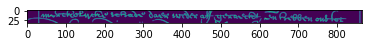

In [ ]:
plt.imshow(sample_img.data.cpu().squeeze().transpose(0,1))

In [ ]:
al = pixelcnn_rec.transform_alignment(sample_cond[None,:].long().to(device))

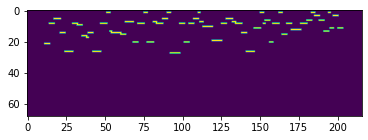

In [ ]:
plt.imshow(al.squeeze().transpose(0,1).data.cpu())

In [ ]:
al.shape

torch.Size([1, 216, 1, 68])

In [ ]:
pixelcnn_gen = pixelcnn_rec.sample(sample_test_cond)

In [ ]:
wavenet_gen = wavenet_rec.sample(sample_test_cond)

In [ ]:
rl_pixelcnn_gen = rl_pixelcnn.sample(sample_test_cond)

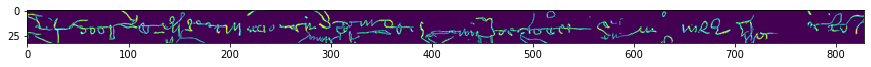

In [ ]:
plot_image(torch.flip(rl_pixelcnn_gen, dims=(1,)))

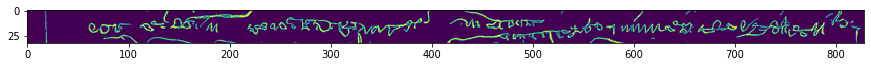

In [ ]:
plot_image(pixelcnn_gen)

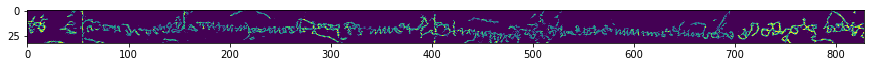

In [ ]:
plot_image(wavenet_gen)

In [ ]:
symbol_counter = Counter()

In [ ]:
for batch in chunked_tasman_loader:
  for alignment in batch["alignment"]:
    alignment = [alphabet[sample.item()] for sample in  alignment]
    sample_counter = Counter(alignment)
    symbol_counter.update(sample_counter)

In [ ]:
symbol_counter

Counter({' ': 30371,
         '(': 47,
         ')': 78,
         '*': 31939,
         ',': 2475,
         '-': 12,
         '/': 6,
         '0': 639,
         '1': 1097,
         '2': 1087,
         '3': 777,
         '4': 1116,
         '5': 597,
         '6': 375,
         '7': 321,
         '8': 511,
         '9': 180,
         ':': 21,
         'A': 453,
         'B': 61,
         'C': 326,
         'D': 375,
         'E': 96,
         'F': 6,
         'G': 341,
         'H': 175,
         'I': 84,
         'J': 111,
         'L': 65,
         'M': 686,
         'N': 139,
         'O': 97,
         'P': 34,
         'R': 22,
         'S': 182,
         'T': 198,
         'V': 52,
         'W': 119,
         'Z': 411,
         'a': 16402,
         'b': 3304,
         'c': 9773,
         'd': 16198,
         'e': 66966,
         'f': 1108,
         'g': 8114,
         'h': 8344,
         'i': 10249,
         'j': 2349,
         'k': 2507,
         'l': 8285,
         'm': 7665,
   

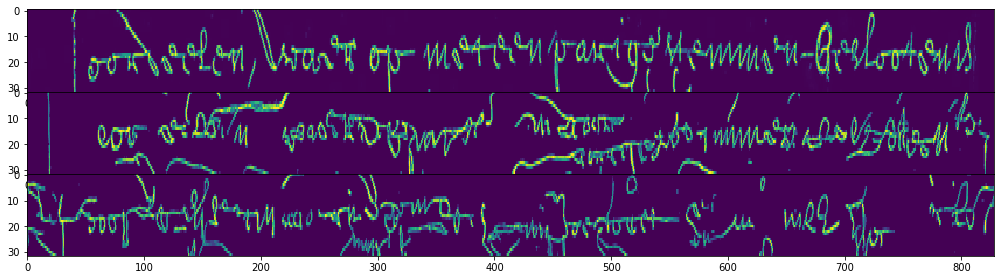

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(14,4))
axs[0].imshow(sample_test_img.squeeze().data.cpu().transpose(0,1), aspect="auto")
axs[1].imshow(pixelcnn_gen.squeeze().data.cpu().transpose(0,1), aspect="auto")
axs[2].imshow(torch.flip(rl_pixelcnn_gen, dims=(1,)).squeeze().data.cpu().transpose(0,1), aspect="auto")
fig.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

## Comparison

In [ ]:
models = [pixelcnn_rec, pixelcnn_rec_no_align, wavenet_rec, wavenet_l_rec, wavenet_no_align_rec, wavenet_lookahead_rec]
models_labels = ["PixelCNN", "PixelCNN no alignment", "WaveNet", "WaveNet L", "WaveNet no alignmenet", "WaveNet Lookahead"]

In [ ]:
models_pixel_cnn = [pixelcnn_rec, pixelcnn_lookahead, pixelcnn_L_rec, pixelcnn_lookahead_no_frac, mock_lr, rl_pixelcnn]
models_pixel_cnn_labels = ["PixelCNN", "PixelCNN Lookahead", "PixelCNN L", "PixelCNN Lookahead no frac", "PixelCNN from bidirectional", "Rigt-to-left PixelCNN"]

In [ ]:
models_wavenet = [wavenet_rec, wavenet_l_rec, wavenet_no_align_rec, wavenet_lookahead_rec, wavenet_lookahead_rec_no_align]
models_wavenet_labels = ["WaveNet", "WaveNet L", "WaveNet no alignmenet", "WaveNet Lookahead", "WaveNet Lookagead no alignment"]

In [ ]:
models = models_pixel_cnn
models_labels = models_pixel_cnn_labels

In [ ]:
models_losses = compare_losses(models, chunked_tasman_test_loader)

In [ ]:
batch_num, models_num = models_losses.shape

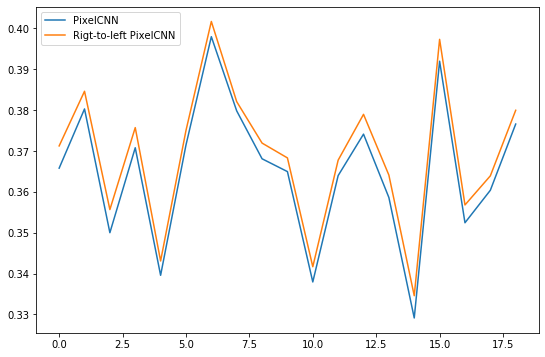

In [ ]:
fig = plt.figure(figsize=(9,6))
for i in range(models_num):
  plt.plot(np.arange(batch_num), models_losses[:,i], label=models_labels[i])
plt.legend()
plt.show()

In [ ]:
column_loss = compare_column_losses(models, sample_chunked_test_batch)

In [ ]:
column_loss_1st = column_loss[0]
column_num = column_loss_1st.shape[0]

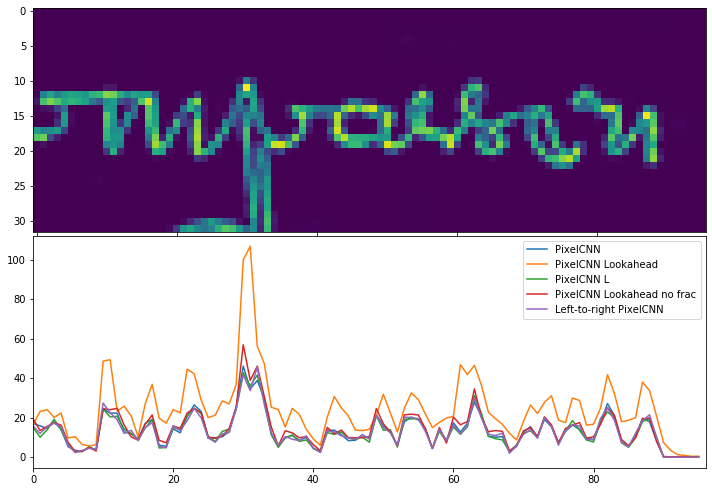

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(10,7))
axs[0].imshow(sample_chunked_test_batch["features"][0].squeeze().transpose(0,1))
for i in range(models_num):
  axs[1].plot(np.arange(column_num), column_loss_1st[:,i], label=models_labels[i])
axs[1].set_xlim(0,column_loss.shape[1])
axs[1].legend()
fig.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()